In [1]:
import pandas as pd
import numpy as np

# Load pieman_segments
pieman_segments = pd.read_csv("pieman_segments.csv")

# Compute row-wise mode of LLM segment indices
segment_cols = [f"segment_idx_{i}" for i in range(6)]
pieman_segments["mode_segment"] = pieman_segments[segment_cols].apply(lambda row: row.mode().iloc[0], axis=1)

# Keep only TR and mode_segment
clean_seg = pieman_segments[["TR", "mode_segment"]].copy()

# Get one row per TR (e.g., first token in TR)
clean_seg = clean_seg.groupby("TR").agg({"mode_segment": "first"}).reset_index()

# Compute segment boundary (no boundary on the first row)
clean_seg["segment_boundary"] = (clean_seg["mode_segment"] != clean_seg["mode_segment"].shift()).astype(int)
clean_seg.loc[0, "segment_boundary"] = 0  # make sure first row is 0

# Create full TR range
full_trs = pd.DataFrame({"TR": range(1, 301)})

# Merge with existing data
clean_seg_full = pd.merge(full_trs, clean_seg, on="TR", how="left")

# Fill missing segment_boundary with 0
clean_seg_full["segment_boundary"] = clean_seg_full["segment_boundary"].fillna(0).astype(int)

# Have ready to feed into cross correlation
event_boundaries = list(clean_seg_full["segment_boundary"])

# Start with segment_boundary as a float list to allow NaNs
event_boundaries = clean_seg_full["segment_boundary"].astype(float).tolist()

event_boundaries = np.array(event_boundaries)

# Set first 13 elements to NaN
event_boundaries[:13] = np.nan

# Set from index 292 to the end to NaN
event_boundaries[292:] = np.nan

# Remove all NaN values
event_boundaries = event_boundaries[~np.isnan(event_boundaries)]

In [2]:
def get_state_transitions(state_vector):
    transitions = np.zeros_like(state_vector)
    transitions[1:] = state_vector[1:] != state_vector[:-1]
    return transitions.astype(int)

subject_list = [
    "sub-002", "sub-003", "sub-004", "sub-005", "sub-006", "sub-007", "sub-008",
    "sub-009", "sub-010", "sub-011", "sub-012", "sub-013", "sub-014", "sub-015",
    "sub-016", "sub-017", "sub-018", "sub-019", "sub-020", "sub-023", "sub-024",
    "sub-025", "sub-026", "sub-027", "sub-028", "sub-029", "sub-030", "sub-031",
    "sub-032", "sub-033", "sub-034", "sub-035", "sub-036", "sub-037", "sub-039",
    "sub-040", "sub-041", "sub-042", "sub-043", "sub-044", "sub-045", "sub-046",
    "sub-047", "sub-048", "sub-049", "sub-050", "sub-051", "sub-052", "sub-053",
    "sub-054", "sub-055", "sub-057", "sub-058", "sub-059", "sub-060", "sub-061",
    "sub-062", "sub-063", "sub-064", "sub-065", "sub-066", "sub-067", "sub-070",
    "sub-071", "sub-072", "sub-073", "sub-074", "sub-075", "sub-076", "sub-077",
    "sub-078", "sub-079", "sub-080", "sub-081", "sub-082"
]

# Import HMM results
# Read in the CSV
df = pd.read_csv("viterbi-paths/statepaths_k10.csv")
# Initialize list to hold state vectors
state_vectors = []
# Loop through each subject (assuming each row is a subject and columns are timepoints named 0 to 279)
for i in range(len(subject_list)):
    # Grab the state time series as a list (convert from row to list of ints)
    state_series = df.loc[i, '0':'278'].astype(int).tolist()
    state_vectors.append(state_series)

transitions_list = []
# Apply get_state_transitions to HMM results for each subject
for i in range(len(subject_list)):
    transitions = get_state_transitions(state_vectors[i])
    transitions_list.append(transitions)

In [3]:
print(len(state_vectors[1]))
print(len(transitions_list[1]))
print(len(event_boundaries))

279
279
279


In [4]:
from scipy.signal import correlate

def cross_correlation(a, b, max_lag=10):
    assert len(a) == len(b)
    a = a - np.mean(a)
    b = b - np.mean(b)
    corr = correlate(a, b, mode='full')
    lags = np.arange(-len(a) + 1, len(a))
    center = len(a) - 1
    lag_range = range(center - max_lag, center + max_lag + 1)
    return lags[lag_range], corr[lag_range]

# Parameters
n_permutations = 500
max_lag = 10

results = {
    "Lags": [],
    "Correlations": [],
    "P_Values": []
}

for i in range(len(subject_list)):
    transition_vector = transitions_list[i]
    transition_vector = np.array(transition_vector)
    event_vector = np.array(event_boundaries)

    # True correlation
    lags, true_corr = cross_correlation(transition_vector, event_vector, max_lag=max_lag)

    # Null distribution via circular shift
    null_corrs = np.zeros((n_permutations, len(true_corr)))

    for p in range(n_permutations):
        shift_amount = np.random.randint(1, len(event_vector))  # exclude 0 shift
        shifted = np.roll(event_vector, shift_amount)
        _, permuted_corr = cross_correlation(transition_vector, shifted, max_lag=max_lag)
        null_corrs[p] = permuted_corr

    # Compute two-tailed p-values
    p_vals = np.mean(np.abs(null_corrs) >= np.abs(true_corr), axis=0)

    # Store results
    results["Lags"].append(lags)
    results["Correlations"].append(true_corr)
    results["P_Values"].append(p_vals)

In [5]:
from statsmodels.stats.multitest import multipletests

# Flatten all p-values to correct across all subjects × lags
all_pvals = np.concatenate(results["P_Values"])
_, pvals_fdr, _, _ = multipletests(all_pvals, alpha=0.05, method='fdr_bh')

# Store FDR-corrected p-values back into results
fdr_corrected = np.split(pvals_fdr, len(subject_list))
results["P_Values_FDR"] = fdr_corrected

In [6]:
flat_results = []
for subj, (lags, corrs, raw_p, fdr_p) in enumerate(zip(
        results["Lags"], results["Correlations"], results["P_Values"], results["P_Values_FDR"])):
    for lag, corr, p, pfdr in zip(lags, corrs, raw_p, fdr_p):
        flat_results.append({
            "Subject": subj + 1,
            "Lag": lag,
            "Correlation": corr,
            "P_Value": p,
            "P_Value_FDR": pfdr
        })

df = pd.DataFrame(flat_results)

# Add significance flag for coloring
df["Significant"] = df["P_Value_FDR"] < 0.05

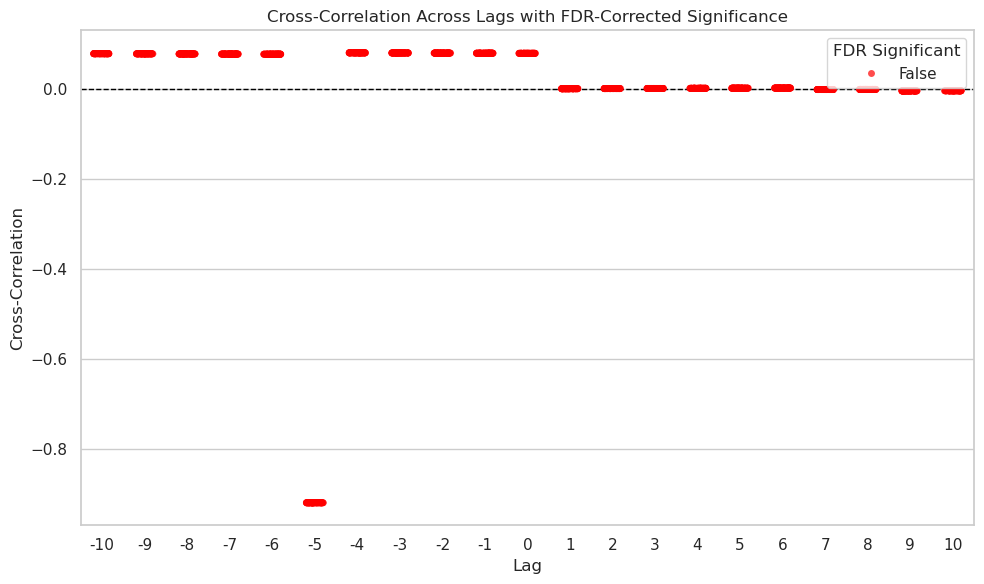

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot with x jitter and exact y-values
sns.stripplot(
    data=df,
    x="Lag",
    y="Correlation",
    hue="Significant",
    palette={True: "green", False: "red"},
    dodge=False,
    jitter=0.2,
    alpha=0.7
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Cross-Correlation Across Lags with FDR-Corrected Significance")
plt.xlabel("Lag")
plt.ylabel("Cross-Correlation")
plt.legend(title="FDR Significant", loc="upper right")
plt.tight_layout()
plt.show()

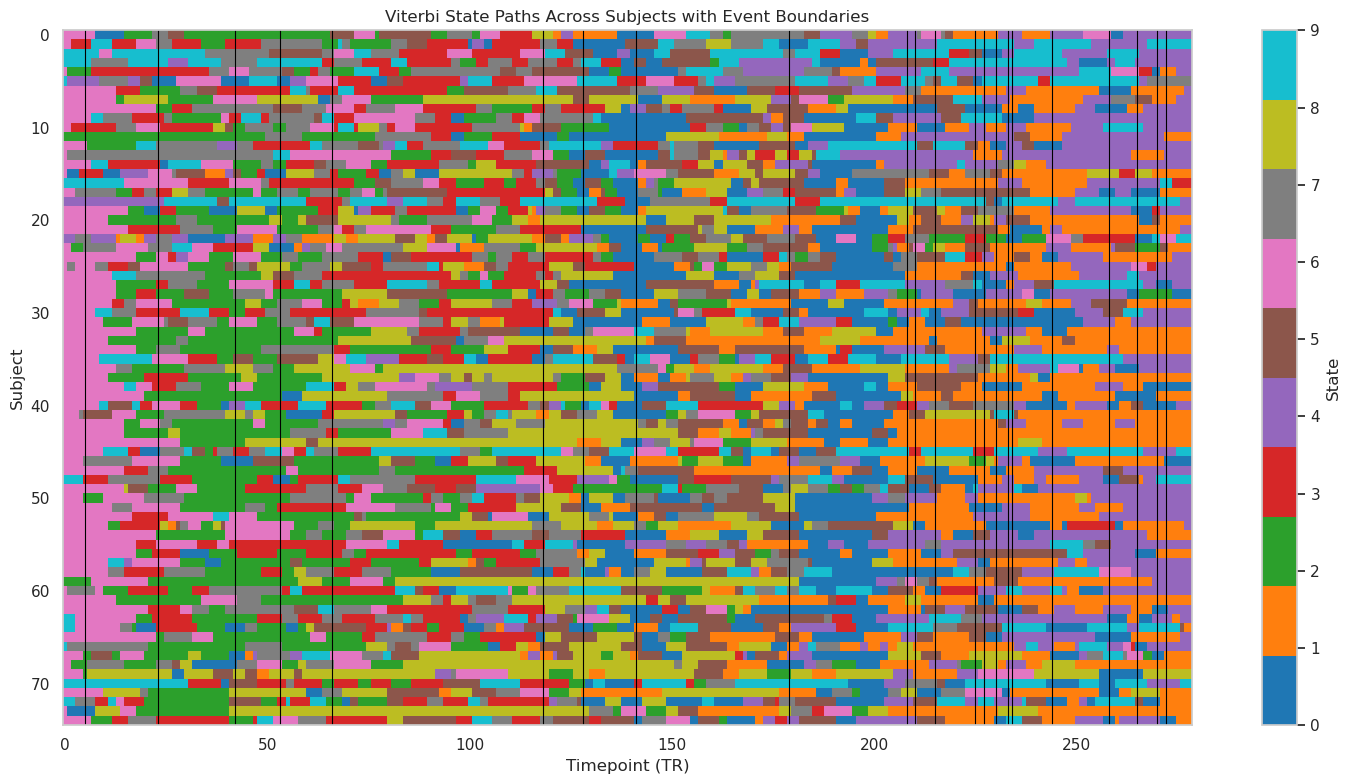

In [12]:
import matplotlib.pyplot as plt

# Convert to NumPy array for easy indexing
state_array = np.array(state_vectors)  # shape: (n_subjects, n_timepoints)
n_subjects, n_timepoints = state_array.shape

# Set up figure
plt.figure(figsize=(15, 8))

# Show image: each row is a subject, each column is a timepoint
# Use 'nearest' to avoid interpolation, and aspect='auto' to fit height
plt.imshow(state_array, aspect='auto', cmap='tab10', interpolation='nearest')

boundary_locs = [i for i, val in enumerate(event_boundaries) if val == 1]
# Overlay vertical dashed lines for event boundaries
for boundary in boundary_locs:
    boundary = int(boundary)
    plt.axvline(x=boundary, color='black', linestyle='-', linewidth=0.8)

# Labels and formatting
plt.xlabel("Timepoint (TR)")
plt.ylabel("Subject")
plt.title("Viterbi State Paths Across Subjects with Event Boundaries")
plt.colorbar(label="State")  # Optional: shows state colors
plt.tight_layout()
plt.grid(False)
plt.show()